In [1]:
import pandas as pd
import numpy as np
import re


In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_CODEGEN_50_82_0_1__2_3_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22
1,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22
2,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__0_1_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22
3,LGBMClassifier,"'DS_CODEGEN_50_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22
4,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__8_9_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_CODEGEN_50_82_0_1__2_3_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
1,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
2,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__0_1_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
3,LGBMClassifier,"'DS_CODEGEN_50_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
4,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__8_9_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , 300, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'hive'," "'monetdb'," "'mssql'," "'mysql'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata'," "'firebird',"]
df.shape (19358, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'hive', BernoulliNB_pipe 18 18
MODEL_DATASETS_MISSING 'hive', GaussianNB_pipe 18 18
MODEL_DATASETS_MISSING 'hive', GradientBoostingClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'hive', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'monetdb', BernoulliNB_pipe 18 18
MODEL_DATASETS_MISSING 'monetdb', EllipticEnvelope_pipe 6 6
MODEL_DATASETS_MISSING 'monetdb', GaussianNB_pipe 18 18
MODEL_DATASETS_MISSING 'monetdb', NuSVC_pipe 18 18
MODEL_DATASETS_MISSING 'monetdb', PolynomialFeatures 18 10
MODEL_DATASETS_MISSING 'monetdb', SVC_pipe 18 18
MODEL_DATASETS_MISSING 'mssql', DecisionTreeClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'mssql', DummyClassifie

In [15]:
missing_data

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,RANSACRegressor,"'DS_CODEGEN_50_22____DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.linear_model
1,RANSACRegressor,"'DS_CODEGEN_50_7____27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.linear_model
2,BernoulliNB,"'DS_CODEGEN_200_82_0_1__8_9_64F62F02',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
3,BernoulliNB_pipe,"'p_DS_CODEGEN_200_22_0_1__0_1_DB7350D0',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
4,BernoulliNB_pipe,"'p_DS_CODEGEN_200_22_0_1__2_3_DB7350D0',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
5,BernoulliNB_pipe,"'p_DS_CODEGEN_200_22_0_1__8_9_DB7350D0',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
6,BernoulliNB_pipe,"'p_DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
7,BernoulliNB_pipe,"'p_DS_CODEGEN_200_7_0_1__2_3_27D91BF6',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
8,BernoulliNB_pipe,"'p_DS_CODEGEN_200_7_0_1__8_9_27D91BF6',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes
9,BernoulliNB_pipe,"'p_DS_CODEGEN_200_82_0_1__0_1_64F62F02',","'hive',",no_dsn,failure,TIMEOUT,300,sklearn.naive_bayes


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(20480, 8)

In [19]:
df.est_dialect.value_counts()

'sqltm',       2048
'mssql',       2048
'teradata',    2048
'hive',        2048
'db2',         2048
'oracle',      2048
'monetdb',     2048
'mysql',       2048
'pgsql',       2048
'firebird',    2048
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'firebird', TIMEOUT                                                       706
'hive',     Error while processing statement  FAILED  Execu...            305
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  198
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  167
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  155
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  145
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  143
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  142
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  142
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  124
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  124
'hive',     Error while processing statement  FAILED  Execu...            122
'monetdb',  TIMEOUT                                                       109
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  103
'teradata', 'DatabaseError:(teradata.api.DatabaseError)                    85
'sqltm',    TIMEOUT                                                        74
'mssql',    TIMEOUT                                                        74
'hive',     TIMEOUT                                                        72
'db2',      'DBAPIError:(ibm_db_dbi.Error)                                 72
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      64
'hive',     Error while processing statement  FAILED  Execu...             51
'mysql',    TIMEOUT                                                        38
'hive',     Error while processing statement  FAILED  Execu...             33
'teradata', TIMEOUT                                                        28
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                      27
'db2',      "AttributeError:'NoneType'                                     18
'mysql',    "AttributeError:'NoneType'                                     18
'firebird', "AttributeError:'NoneType'                                     18
'mssql',    "AttributeError:'NoneType'                                     18
'pgsql',    "AttributeError:'NoneType'                                     18
...                                                                       ...
'mysql',    "InternalError:(_mysql_exceptions.InternalError)                6
'sqltm',    ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'monetdb',  ) Math exception: Numerical result out of rang                  6
'teradata', "DatabaseError:(teradata.api.DatabaseError)                     6
'db2',      : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'pgsql',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'sqltm',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'firebird', 'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'teradata', 'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'oracle',   'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'hive',     'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'mysql',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'monetdb',  'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'mssql',    'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          3
'hive',     Error running query  java.lang.StackOverflowErr...              2
'monetdb',  'DBAPIError:(builtins.BrokenPipeError)                          2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'db2',  

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,16856
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",1443
TIMEOUT,1122
"Error while processing statement FAILED Execution Error, return code 1 from org.apache.hadoop.hive.ql.exec.mr.MapRedTask",305
"""AttributeError:'NoneType'",180
"Error while processing statement FAILED Execution Error, return code -101 from org.apache.hadoop.hive.ql.exec.mr.MapRedTask. java.io.IOException",122
'DatabaseError:(teradata.api.DatabaseError),85
'DBAPIError:(ibm_db_dbi.Error),72
'DatabaseError:(fdb.fbcore.DatabaseError),64
"Error while processing statement FAILED Execution Error, return code 2 from org.apache.hadoop.hive.ql.exec.mr.MapRedTask",51


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

MiniBatchSparsePCA             180
SparsePCA                      180
DummyClassifier                180
LatentDirichletAllocation      174
NMF                            168
DummyClassifier_pipe           144
OneVsRestClassifier             72
IsolationForest_pipe            57
IsolationForest                 56
NuSVC_pipe                      42
OneVsRestClassifier_pipe        27
FastICA                         27
FactorAnalysis                  18
ExtraTreesClassifier_pipe       11
XGBClassifier                   11
ExtraTreesClassifier            10
Lars                             9
XGBClassifier_pipe               9
AdaBoostClassifier               8
BaggingClassifier_pipe           6
AdaBoostClassifier_pipe          6
BaggingClassifier                5
CalibratedClassifierCV           5
RandomForestClassifier_pipe      5
SVC                              4
RandomForestClassifier           4
OneVsOneClassifier               3
SVC_pipe                         3
OneVsOneClassifier_p

In [28]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [29]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [30]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_CODEGEN_50_82_0_1__2_3_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
1,LGBMClassifier,"'DS_CODEGEN_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
2,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__0_1_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
3,LGBMClassifier,"'DS_CODEGEN_50_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn
4,LGBMClassifier,"'DS_CODEGEN_200_82_0_1__8_9_64F62F02',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,22,lightgbm.sklearn


In [31]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [32]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']

In [33]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_CODEGEN_50_82_0_1__2_3_64F62F02,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,22,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_CODEGEN_200_7_0_1__0_1_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,22,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_CODEGEN_200_82_0_1__0_1_64F62F02,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,22,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_CODEGEN_50_22_0_1__0_1_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,22,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_CODEGEN_200_82_0_1__8_9_64F62F02,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,22,lightgbm.sklearn,1,db2


In [34]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird  hive monetdb mssql mysql oracle   
model_category                                                                  
lightgbm.sklearn                 48       48    48      48    48    48     48   
sklearn.calibration              36       36    36      36    36    36     36   
sklearn.covariance               12       12    12      12    12    12     12   
sklearn.decomposition           180      180   180     180   180   180    180   
sklearn.discriminant_analysis    36       36    36      36    36    36     36   
sklearn.ensemble                252      252   252     252   252   252    252   
sklearn.feature_selection       162      162   162     162   162   162    162   
sklearn.kernel_ridge             12       12    12      12    12    12     12   
sklearn.linear_model            482      482   482     482   482   482    482   
sklearn.multiclass               72       72    72      72    72    72     72   
sklearn.naive_bayes              90       90    90      90    90    90     90   
sklearn.neural_network           48       48    48      48    48    48     48   
sklearn.pipeline                 54       54    54      54    54    54     54   
sklearn.preprocessing           216      216   216     216   216   216    216   
sklearn.svm                     156      156   156     156   156   156    156   
sklearn.tree                     96       96    96      96    96    96     96   
xgboost.sklearn                  48       48    48      48    48    48     48   
All                            2000     2000  2000    2000  2000  2000   2000   

                                                           
dialect                       pgsql sqltm teradata    All  
model_category                                             
lightgbm.sklearn                 48    48       48    480  
sklearn.calibration              36    36       36    360  
sklearn.covariance               12    12       12    120  
sklearn.decomposition           180   180      180   1800  
sklearn.discriminant_analysis    36    36       36    360  
sklearn.ensemble                252   252      252   2520  
sklearn.feature_selection       162   162      162   1620  
sklearn.kernel_ridge             12    12       12    120  
sklearn.linear_model            482   482      482   4820  
sklearn.multiclass               72    72       72    720  
sklearn.naive_bayes              90    90       90    900  
sklearn.neural_network           48    48       48    480  
sklearn.pipeline                 54    54       54    540  
sklearn.preprocessing           216   216      216   2160  
sklearn.svm                     156   156      156   1560  
sklearn.tree                     96    96       96    960  
xgboost.sklearn                  48    48       48    480  
All                            2000  2000     2000  20000

In [35]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [36]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird      hive   monetdb   
model_category                                                          
lightgbm.sklearn               0.000000  1.000000  1.000000  0.000000   
sklearn.calibration            0.000000  0.972222  0.361111  0.222222   
sklearn.covariance             0.166667  0.166667  0.666667  0.666667   
sklearn.decomposition          0.516667  0.550000  0.516667  0.616667   
sklearn.discriminant_analysis  0.000000  0.500000  0.250000  0.000000   
sklearn.ensemble               0.051587  0.821429  0.750000  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.666667  1.000000  0.083333   
sklearn.linear_model           0.008299  0.263485  0.087137  0.002075   
sklearn.multiclass             0.166667  0.944444  0.833333  0.166667   
sklearn.naive_bayes            0.066667  0.666667  0.888889  0.577778   
sklearn.neural_network         1.000000  0.750000  0.770833  0.000000   
sklearn.pipeline               0.000000  0.000000  0.018519  0.000000   
sklearn.preprocessing          0.111111  0.083333  0.004630  0.046296   
sklearn.svm                    0.057692  0.711538  0.371795  0.352564   
sklearn.tree                   0.000000  0.000000  0.833333  0.000000   
xgboost.sklearn                0.000000  1.000000  0.979167  0.000000   
All                            0.106000  0.442500  0.389000  0.135000   

                                                                       \
dialect                           mssql     mysql    oracle     pgsql   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.166667  0.083333  0.166667   
sklearn.decomposition          0.516667  0.516667  0.516667  0.516667   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.119048  0.126984  0.047619  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.083333  0.083333  0.083333  0.083333   
sklearn.linear_model           0.043568  0.043568  0.006224  0.006224   
sklearn.multiclass             0.166667  0.208333  0.166667  0.166667   
sklearn.naive_bayes            0.022222  0.044444  0.000000  0.066667   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.000000  0.027778   
sklearn.svm                    0.051282  0.051282  0.147436  0.051282   
sklearn.tree                   0.187500  0.000000  0.000000  0.000000   
xgboost.sklearn                0.000000  0.000000  0.000000  0.000000   
All                            0.093500  0.088000  0.072500  0.071500   

                                                             
dialect                           sqltm  teradata       All  
model_category                                               
lightgbm.sklearn               0.000000  0.062500  0.206250  
sklearn.calibration            0.500000  0.000000  0.205556  
sklearn.covariance             0.166667  0.166667  0.258333  
sklearn.decomposition          0.516667  0.516667  0.530000  
sklearn.discriminant_analysis  0.000000  0.000000  0.075000  
sklearn.ensemble               0.047619  0.214286  0.227381  
sklearn.feature_selection      0.000000  0.000000  0.000000  
sklearn.kernel_ridge           0.083333  0.083333  0.233333  
sklearn.linear_model           0.080913  0.043568  0.058506  
sklearn.multiclass             0.166667  0.208333  0.319444  
sklearn.naive_bayes            0.000000  0.222222  0.255556  
sklearn.neural_network         0.000000  0.000000  0.252083  
sklearn.pipeline               0.0000

In [37]:
df.to_csv('report_extensive_tests.csv')

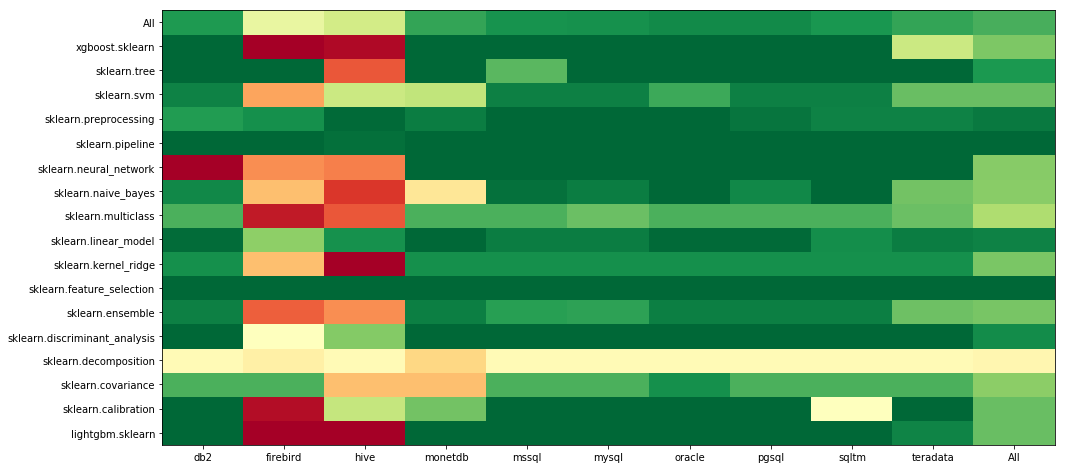

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [39]:
Category_Labels = df.model_category.unique()


In [40]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [41]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        48
'firebird', TIMEOUT                                                        48
'hive',     Error while processing statement  FAILED  Execu...             23
            Error while processing statement  FAILED  Execu...             14
            Error while processing statement  FAILED  Execu...             11
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        45
            'DatabaseError:(teradata.api.DatabaseError)                     3

mean                                                       \
dialect              db2 firebird hive monetdb mssql mysql oracle pgsql sqltm   
Model                                                                           
LGBMClassifier       0.0      1.0  1.0     0.0   0.0   0.0    0.0   0.0   0.0   
LGBMClassifier_pipe  0.0      1.0  1.0     0.0   0.0   0.0    0.0   0.0   0.0   
LGBMRegressor        0.0      1.0  1.0     0.0   0.0   0.0    0.0   0.0   0.0   
LGBMRegressor_pipe   0.0      1.0  1.0     0.0   0.0   0.0    0.0   0.0   0.0   
All                  0.0      1.0  1.0     0.0   0.0   0.0    0.0   0.0   0.0   

                                         
dialect              teradata       All  
Model                                    
LGBMClassifier       0.000000  0.200000  
LGBMClassifier_pipe  0.166667  0.216667  
LGBMRegressor        0.000000  0.200000  
LGBMRegressor_pipe   0.000000  0.200000  
All                  0.062500  0.206250

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        36
'firebird', TIMEOUT                                                        35
            SUCCESS                                                         1
'hive',     SUCCESS                                                        23
            Error while processing statement  FAILED  Execu...              7
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'monetdb',  SUCCESS                                                        28
            TIMEOUT                                                         8
'mssql',    SUCCESS                                                        36
'mysql',    SUCCESS                                                        36
'oracle',   SUCCESS                                                        36
'pgsql',    SUCCESS                                                        36
'sqltm',    SUCCESS                                                        18
            TIMEOUT                                                        18
'teradata', SUCCESS                                                        36

mean                                            \
dialect                      db2  firebird      hive   monetdb mssql mysql   
Model                                                                        
CalibratedClassifierCV       0.0  0.944444  0.388889  0.000000   0.0   0.0   
CalibratedClassifierCV_pipe  0.0  1.000000  0.333333  0.444444   0.0   0.0   
All                          0.0  0.972222  0.361111  0.222222   0.0   0.0   

                                                                   
dialect                     oracle pgsql sqltm teradata       All  
Model                                                              
CalibratedClassifierCV         0.0   0.0   0.0      0.0  0.133333  
CalibratedClassifierCV_pipe    0.0   0.0   1.0      0.0  0.277778  
All                            0.0   0.0   0.5      0.0  0.205556

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'hive',     Error while processing statement  FAILED  Execu...              6
            SUCCESS                                                         4
            Error running query  java.lang.StackOverflowErr...              2
'monetdb',  TIMEOUT                                                         7
            SUCCESS                                                         4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird      hive   monetdb     mssql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  1.000000  1.000000  0.000000   
All                    0.166667  0.166667  0.666667  0.666667  0.166667   

                                                                         \
dialect                   mysql    oracle     pgsql     sqltm  teradata   
Model                                                                     
EllipticEnvelope       0.333333  0.166667  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.000000   
All                    0.166667  0.083333  0.166667  0.166667  0.166667   

                                 
dialect                     All  
Model                            
EllipticEnvelope       0.316667  
EllipticEnvelope_pipe  0.200000  
All                    0.258333

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'firebird', SUCCESS                                                  81
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             54
            "AttributeError:'NoneType'                               18
            "DatabaseError:(fdb.fbcore.DatabaseError)                15
            'DatabaseError:(fdb.fbcore.DatabaseError)                12
'hive',     SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             93
            SUCCESS                                                  69
            "AttributeError:'NoneType'                               18
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18
'teradata', SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             75
            "AttributeError:'NoneType'                               18

mean                                          \
dialect                         db2  firebird      hive   monetdb     mssql   
Model                                                                         
FactorAnalysis             0.000000  0.000000  0.000000  1.000000  0.000000   
FastICA                    0.166667  0.333333  0.166667  0.166667  0.166667   
IncrementalPCA             0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
LatentDirichletAllocation  1.000000  1.000000  1.000000  1.000000  1.000000   
MiniBatchSparsePCA         1.000000  1.000000  1.000000  1.000000  1.000000   
NMF                        1.000000  1.000000  1.000000  1.000000  1.000000   
PCA                        0.000000  0.000000  0.000000  0.000000  0.000000   
SparsePCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
TruncatedSVD               0.000000  0.166667  0.000000  0.000000  0.000000   
All                        0.516667  0.550000  0.516667  0.616667  0.516667   

                                                                             \
dialect                       mysql    oracle     pgsql     sqltm  teradata   
Model                                                                         
FactorAnalysis             0.000000  0.000000  0.000000  0.000000  0.000000   
FastICA                    0.166667  0.166667  0.166667  0.166667  0.166667   
IncrementalPCA             0.000000  0.000000  0.000000  0.000000  0.000000   
KernelPCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
LatentDirichletAllocation  1.000000  1.000000  1.000000  1.000000  1.000000   
MiniBatchSparsePCA         1.000000  1.000000  1.000000  1.000000  1.000000   
NMF                        1.000000  1.000000  1.000000  1.000000  1.000000   
PCA                        0.000000  0.000000  0.000000  0.000000  0.000000   
SparsePCA                  1.000000  1.000000  1.000000  1.000000  1.000000   
TruncatedSVD               0.000000  0.000000  0.000000  0.000000  0.000000   
All                        0.516667  0.516667  0.516667  0.516667  0.516667   

                                     
dialect                         All  
Model                                
FactorAnalysis             0.100000  
FastICA                    0.183333  
IncrementalPCA             0.000000  
KernelPCA                  1.000000  
LatentDirichletAllocation  1.000000  
MiniBatchSparsePCA         1.000000  
NMF                        1.000000  
PCA                        0.000000  
SparsePCA                  1.000000  
TruncatedSVD               0.016667  
All                        0.530000

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        36
'firebird', SUCCESS                                                        18
            TIMEOUT                                                        18
'hive',     SUCCESS                                                        27
            Error while processing statement  FAILED  Execu...              4
            Error while processing statement  FAILED  Execu...              3
            Error while processing statement  FAILED  Execu...              2
'monetdb',  SUCCESS                                                        36
'mssql',    SUCCESS                                                        36
'mysql',    SUCCESS                                                        36
'oracle',   SUCCESS                                                        36
'pgsql',    SUCCESS                                                        36
'sqltm',    SUCCESS                                                        36
'teradata', SUCCESS                                                        36

mean                                         \
dialect                          db2 firebird      hive monetdb mssql mysql   
Model                                                                         
LinearDiscriminantAnalysis       0.0      0.0  0.388889     0.0   0.0   0.0   
LinearDiscriminantAnalysis_pipe  0.0      1.0  0.111111     0.0   0.0   0.0   
All                              0.0      0.5  0.250000     0.0   0.0   0.0   

                                                                       
dialect                         oracle pgsql sqltm teradata       All  
Model                                                                  
LinearDiscriminantAnalysis         0.0   0.0   0.0      0.0  0.038889  
LinearDiscriminantAnalysis_pipe    0.0   0.0   0.0      0.0  0.111111  
All                                0.0   0.0   0.0      0.0  0.075000

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       239
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', TIMEOUT                                                       195
            SUCCESS                                                        45
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'hive',     Error while processing statement  FAILED  Execu...            116
            SUCCESS                                                        63
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   53
            TIMEOUT                                                        20
'monetdb',  SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                       222
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mysql',    SUCCESS                                                       220
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            "InternalError:(_mysql_exceptions.InternalError)                2
'oracle',   SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'pgsql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'sqltm',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'teradata', SUCCESS                                                       198
            'DatabaseError:(teradata.api.DatabaseError)                    28
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   26

mean                                \
dialect                               db2  firebird      hive   monetdb   
Model                                                                     
AdaBoostClassifier               0.000000  1.000000  0.666667  0.000000   
AdaBoostClassifier_pipe          0.000000  1.000000  0.444444  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.666667  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.833333  0.000000   
BaggingClassifier                0.000000  0.944444  0.777778  0.000000   
BaggingClassifier_pipe           0.000000  1.000000  0.777778  0.000000   
BaggingRegressor                 0.000000  0.333333  0.500000  0.000000   
BaggingRegressor_pipe            0.000000  1.000000  0.666667  0.000000   
ExtraTreesClassifier             0.000000  1.000000  0.777778  0.000000   
ExtraTreesClassifier_pipe        0.000000  1.000000  0.833333  0.000000   
ExtraTreesRegressor              0.000000  0.500000  0.666667  0.000000   
ExtraTreesRegressor_pipe         0.000000  1.000000  0.333333  0.000000   
GradientBoostingClassifier       0.000000  1.000000  1.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  1.000000  1.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.500000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.666667  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.944444  0.833333  0.000000   
RandomForestClassifier_pipe      0.055556  1.000000  0.666667  0.000000   
RandomForestRegressor            0.000000  0.000000  0.666667  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.666667  0.000000   
All                              0.051587  0.821429  0.750000  0.047619   

                                                                         \
dialect                             mssql     mysql    oracle     pgsql   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        1.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.111111  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  1.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.119048  0.126984  0.047619  0.047619   

                                                               
dialect                             sqltm  teradata       All  
Model  

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,162
"'firebird',",SUCCESS,162
"'hive',",SUCCESS,162
"'monetdb',",SUCCESS,162
"'mssql',",SUCCESS,162
"'mysql',",SUCCESS,162
"'oracle',",SUCCESS,162
"'pgsql',",SUCCESS,162
"'sqltm',",SUCCESS,162


mean                                                 \
dialect                  db2 firebird hive monetdb mssql mysql oracle pgsql   
Model                                                                         
GenericUnivariateSelect    0        0    0       0     0     0      0     0   
RFE                        0        0    0       0     0     0      0     0   
RFECV                      0        0    0       0     0     0      0     0   
SelectFdr                  0        0    0       0     0     0      0     0   
SelectFpr                  0        0    0       0     0     0      0     0   
SelectFromModel            0        0    0       0     0     0      0     0   
SelectFwe                  0        0    0       0     0     0      0     0   
SelectKBest                0        0    0       0     0     0      0     0   
SelectPercentile           0        0    0       0     0     0      0     0   
All                        0        0    0       0     0     0      0     0   

                                            
dialect                 sqltm teradata All  
Model                                       
GenericUnivariateSelect     0        0   0  
RFE                         0        0   0  
RFECV                       0        0   0  
SelectFdr                   0        0   0  
SelectFpr                   0        0   0  
SelectFromModel             0        0   0  
SelectFwe                   0        0   0  
SelectKBest                 0        0   0  
SelectPercentile            0        0   0  
All                         0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'firebird', TIMEOUT                                                         6
            SUCCESS                                                         4
            'DatabaseError:(fdb.fbcore.DatabaseError)                       1
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'hive',     Error while processing statement  FAILED  Execu...              6
            Error while processing statement  FAILED  Execu...              5
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'monetdb',  SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'mssql',    SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'mysql',    SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'oracle',   SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'pgsql',    SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'sqltm',    SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1
'teradata', SUCCESS                                                        11
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          1

mean                                               \
dialect                db2  firebird hive   monetdb     mssql     mysql   
Model                                                                     
KernelRidge       0.166667  0.333333  1.0  0.166667  0.166667  0.166667   
KernelRidge_pipe  0.000000  1.000000  1.0  0.000000  0.000000  0.000000   
All               0.083333  0.666667  1.0  0.083333  0.083333  0.083333   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
KernelRidge       0.166667  0.166667  0.166667  0.166667  0.266667  
KernelRidge_pipe  0.000000  0.000000  0.000000  0.000000  0.200000  
All               0.083333  0.083333  0.083333  0.083333  0.233333

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       478
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       355
            TIMEOUT                                                       126
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'hive',     SUCCESS                                                       440
            Error while processing statement  FAILED  Execu...             39
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'monetdb',  SUCCESS                                                       481
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                       461
            TIMEOUT                                                        20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mysql',    SUCCESS                                                       461
            TIMEOUT                                                        20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                       443
            TIMEOUT                                                        38
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                       461
            TIMEOUT                                                        20
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                                db2  firebird      hive   monetdb   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  0.166667  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.166667  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.000000  0.222222  0.000000   
LogisticRegressionCV              0.000000  0.000000  0.166667  0.000000   
LogisticRegressionCV_pipe         0.000000  1.000000  0.388889  0.000000   
LogisticRegression_pipe           0.000000  1.000000  0.111111  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.277778  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  1.000000  0.055556  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.111111  0.000000   
Perceptron_pipe                   0.000000  1.000000  0.222222  0.000000   
RANSACRegressor                   1.000000  0.000000  1.000000  0.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.111111  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  1.000000  0.111111  0.000000   
RidgeClassifier_pipe              0.000000  1.000000  0.111111  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.222222  0.000000   
SGDClassifier_pipe                0.000000  1.000000  0.055556  0.000000   
SGDRegressor                      0.000000  0.000000  0.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'firebird', TIMEOUT                                                        53
            'DatabaseError:(fdb.fbcore.DatabaseError)                      15
            SUCCESS                                                         4
'hive',     Error while processing statement  FAILED  Execu...             34
            Error while processing statement  FAILED  Execu...             14
            SUCCESS                                                        12
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            Error while processing statement  FAILED  Execu...              4
            Error while processing statement  FAILED  Execu...              2
'monetdb',  SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mysql',    SUCCESS                                                        57
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   15
'oracle',   SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'pgsql',    SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'sqltm',    SUCCESS                                                        60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'teradata', SUCCESS                                                        57
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            'DatabaseError:(teradata.api.DatabaseError)                     3

mean                                          \
dialect                        db2  firebird      hive   monetdb     mssql   
Model                                                                        
OneVsOneClassifier        0.000000  0.944444  0.722222  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  1.000000  0.611111  0.000000  0.000000   
OneVsRestClassifier       0.500000  0.833333  1.000000  0.500000  0.500000   
OneVsRestClassifier_pipe  0.166667  1.000000  1.000000  0.166667  0.166667   
All                       0.166667  0.944444  0.833333  0.166667  0.166667   

                                                                            \
dialect                      mysql    oracle     pgsql     sqltm  teradata   
Model                                                                        
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsRestClassifier       0.500000  0.500000  0.500000  0.500000  0.500000   
OneVsRestClassifier_pipe  0.333333  0.166667  0.166667  0.166667  0.333333   
All                       0.208333  0.166667  0.166667  0.166667  0.208333   

                                    
dialect                        All  
Model                               
OneVsOneClassifier        0.166667  
OneVsOneClassifier_pipe   0.161111  
OneVsRestClassifier       0.583333  
OneVsRestClassifier_pipe  0.366667  
All                       0.319444

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        84
            'DBAPIError:(ibm_db_dbi.Error)                                  6
'firebird', TIMEOUT                                                        36
            SUCCESS                                                        30
            "DatabaseError:(fdb.fbcore.DatabaseError)                      12
            'DatabaseError:(fdb.fbcore.DatabaseError)                      12
'hive',     TIMEOUT                                                        42
            Error while processing statement  FAILED  Execu...             20
            SUCCESS                                                        10
            Error running query  java.lang.OutOfMemoryError...              9
            Error while processing statement  FAILED  Execu...              9
'monetdb',  TIMEOUT                                                        40
            SUCCESS                                                        38
            ) Math exception: Numerical result out of rang                  6
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              4
            'DBAPIError:(builtins.BrokenPipeError)                          2
'mssql',    SUCCESS                                                        88
            701, b"There is insufficient system memory in r...              2
'mysql',    SUCCESS                                                        86
            "InternalError:(_mysql_exceptions.InternalError)                4
'oracle',   SUCCESS                                                        90
'pgsql',    SUCCESS                                                        84
            ) value out of range: underflo                                  6
'sqltm',    SUCCESS                                                        90
'teradata', SUCCESS                                                        70
            'DatabaseError:(teradata.api.DatabaseError)                    18
            TIMEOUT                                                         2

mean                                                    \
dialect                db2  firebird      hive   monetdb     mssql     mysql   
Model                                                                          
BernoulliNB       0.000000  1.000000  0.944444  0.222222  0.000000  0.000000   
BernoulliNB_pipe  0.000000  1.000000  1.000000  1.000000  0.000000  0.000000   
GaussianNB        0.333333  0.333333  0.944444  0.388889  0.111111  0.000000   
GaussianNB_pipe   0.000000  1.000000  1.000000  1.000000  0.000000  0.222222   
MultinomialNB     0.000000  0.000000  0.555556  0.277778  0.000000  0.000000   
All               0.066667  0.666667  0.888889  0.577778  0.022222  0.044444   

                                                             
dialect          oracle     pgsql sqltm  teradata       All  
Model                                                        
BernoulliNB         0.0  0.000000   0.0  0.333333  0.250000  
BernoulliNB_pipe    0.0  0.000000   0.0  0.000000  0.300000  
GaussianNB          0.0  0.333333   0.0  0.666667  0.311111  
GaussianNB_pipe     0.0  0.000000   0.0  0.111111  0.333333  
MultinomialNB       0.0  0.000000   0.0  0.000000  0.083333  
All                 0.0  0.066667   0.0  0.222222  0.255556

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      'DBAPIError:(ibm_db_dbi.Error)                                 48
'firebird', TIMEOUT                                                        36
            SUCCESS                                                        12
'hive',     Error while processing statement  FAILED  Execu...             21
            Error while processing statement  FAILED  Execu...             13
            SUCCESS                                                        11
            Error while processing statement  FAILED  Execu...              3
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                                      \
dialect             db2 firebird      hive monetdb mssql mysql oracle pgsql   
Model                                                                         
MLPClassifier       1.0     1.00  1.000000     0.0   0.0   0.0    0.0   0.0   
MLPClassifier_pipe  1.0     1.00  1.000000     0.0   0.0   0.0    0.0   0.0   
MLPRegressor        1.0     0.00  0.000000     0.0   0.0   0.0    0.0   0.0   
MLPRegressor_pipe   1.0     0.00  0.166667     0.0   0.0   0.0    0.0   0.0   
All                 1.0     0.75  0.770833     0.0   0.0   0.0    0.0   0.0   

                                             
dialect            sqltm teradata       All  
Model                                        
MLPClassifier        0.0      0.0  0.300000  
MLPClassifier_pipe   0.0      0.0  0.300000  
MLPRegressor         0.0      0.0  0.100000  
MLPRegressor_pipe    0.0      0.0  0.116667  
All                  0.0      0.0  0.252083

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  54
'firebird', SUCCESS                                                  54
'hive',     SUCCESS                                                  53
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              1
'monetdb',  SUCCESS                                                  54
'mssql',    SUCCESS                                                  54
'mysql',    SUCCESS                                                  54
'oracle',   SUCCESS                                                  54
'pgsql',    SUCCESS                                                  54
'sqltm',    SUCCESS                                                  54
'teradata', SUCCESS                                                  54

mean                                                            \
dialect        db2 firebird      hive monetdb mssql mysql oracle pgsql sqltm   
Model                                                                          
FeatureUnion   0.0      0.0  0.000000     0.0   0.0   0.0    0.0   0.0   0.0   
Pipeline       0.0      0.0  0.055556     0.0   0.0   0.0    0.0   0.0   0.0   
Pipeline_pipe  0.0      0.0  0.000000     0.0   0.0   0.0    0.0   0.0   0.0   
All            0.0      0.0  0.018519     0.0   0.0   0.0    0.0   0.0   0.0   

                                  
dialect       teradata       All  
Model                             
FeatureUnion       0.0  0.000000  
Pipeline           0.0  0.005556  
Pipeline_pipe      0.0  0.000000  
All                0.0  0.001852

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       192
            'DBAPIError:(ibm_db_dbi.Error)                                 18
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
'firebird', SUCCESS                                                       198
            'DatabaseError:(fdb.fbcore.DatabaseError)                      18
'hive',     SUCCESS                                                       215
            Error while processing statement  FAILED  Execu...              1
'monetdb',  SUCCESS                                                       206
            TIMEOUT                                                        10
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       204
            "DatabaseError:(teradata.api.DatabaseError)                     6
            TIMEOUT                                                         6

mean                                            \
dialect                   db2  firebird      hive   monetdb mssql mysql   
Model                                                                     
Binarizer            0.000000  0.000000  0.000000  0.000000   0.0   0.0   
Imputer              0.000000  0.000000  0.000000  0.000000   0.0   0.0   
LabelBinarizer       0.000000  0.000000  0.000000  0.000000   0.0   0.0   
LabelEncoder         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
MinMaxScaler         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
Normalizer           0.000000  0.000000  0.000000  0.000000   0.0   0.0   
OneHotEncoder        0.000000  0.000000  0.000000  0.000000   0.0   0.0   
PolynomialFeatures   0.333333  0.333333  0.000000  0.555556   0.0   0.0   
QuantileTransformer  1.000000  0.666667  0.055556  0.000000   0.0   0.0   
RobustScaler         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
StandardScaler       0.000000  0.000000  0.000000  0.000000   0.0   0.0   
All                  0.111111  0.083333  0.004630  0.046296   0.0   0.0   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
Binarizer              0.0  0.000000  0.000000  0.000000  0.000000  
Imputer                0.0  0.000000  0.000000  0.000000  0.000000  
LabelBinarizer         0.0  0.000000  0.000000  0.000000  0.000000  
LabelEncoder           0.0  0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler           0.0  0.000000  0.000000  0.000000  0.000000  
MinMaxScaler           0.0  0.000000  0.000000  0.000000  0.000000  
Normalizer             0.0  0.000000  0.000000  0.000000  0.000000  
OneHotEncoder          0.0  0.000000  0.000000  0.000000  0.000000  
PolynomialFeatures     0.0  0.333333  0.333333  0.333333  0.222222  
QuantileTransformer    0.0  0.000000  0.333333  0.333333  0.238889  
RobustScaler           0.0  0.000000  0.000000  0.000000  0.000000  
StandardScaler         0.0  0.000000  0.000000  0.000000  0.000000  
All                    0.0  0.027778  0.055556  0.055556  0.038426

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       147
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', TIMEOUT                                                       105
            SUCCESS                                                        45
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'hive',     SUCCESS                                                        98
            Error while processing statement  FAILED  Execu...             32
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   16
            TIMEOUT                                                         8
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'monetdb',  SUCCESS                                                       101
            TIMEOUT                                                        44
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              9
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'mssql',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'mysql',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'oracle',   SUCCESS                                                       133
            TIMEOUT                                                        15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'pgsql',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'sqltm',    SUCCESS                                                       148
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2
'teradata', SUCCESS                                                       124
            'DatabaseError:(teradata.api.DatabaseError)                    30
            'Exception:TOO_LARGE_SQL_UNION_AVOIDED                          2

mean                                                    \
dialect                db2  firebird      hive   monetdb     mssql     mysql   
Model                                                                          
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  1.000000  0.166667  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  0.944444  0.777778  0.166667  0.000000  0.000000   
NuSVC_pipe        0.388889  1.000000  0.833333  1.000000  0.333333  0.333333   
NuSVR             0.000000  0.166667  0.000000  1.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.833333  0.000000  0.500000  0.000000  0.000000   
OneClassSVM       0.166667  0.333333  0.166667  0.166667  0.166667  0.166667   
OneClassSVM_pipe  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.944444  0.444444  0.277778  0.000000  0.000000   
SVC_pipe          0.000000  1.000000  0.888889  1.000000  0.000000  0.000000   
SVR               0.166667  0.500000  0.166667  0.166667  0.166667  0.166667   
SVR_pipe          0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
All               0.057692  0.711538  0.371795  0.352564  0.051282  0.051282   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.000000  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  0.116667  
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  
NuSVC             0.000000  0.000000  0.000000  0.500000  0.238889  
NuSVC_pipe        0.333333  0.333333  0.333333  0.500000  0.538889  
NuSVR             0.000000  0.000000  0.000000  0.000000  0.116667  
NuSVR_pipe        0.000000  0.000000  0.000000  0.000000  0.133333  
OneClassSVM       0.166667  0.166667  0.166667  0.166667  0.183333  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.000000  0.100000  
SVC               0.000000  0.000000  0.000000  0.333333  0.200000  
SVC_pipe          0.833333  0.000000  0.000000  0.333333  0.405556  
SVR               0.166667  0.166667  0.166667  0.166667  0.200000  
SVR_pipe          0.000000  0.000000  0.000000  0.000000  0.100000  
All               0.147436  0.051282  0.051282  0.205128  0.205128

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        96
'firebird', SUCCESS                                                        96
'hive',     Error while processing statement  FAILED  Execu...             57
            Error while processing statement  FAILED  Execu...             20
            SUCCESS                                                        16
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            Error running query  org.apache.hadoop.fs.FSErr...              1
'monetdb',  SUCCESS                                                        96
'mssql',    SUCCESS                                                        78
            TIMEOUT                                                        18
'mysql',    SUCCESS                                                        96
'oracle',   SUCCESS                                                        96
'pgsql',    SUCCESS                                                        96
'sqltm',    SUCCESS                                                        96
'teradata', SUCCESS                                                        96

mean                                           \
dialect                      db2 firebird      hive monetdb   mssql mysql   
Model                                                                       
DecisionTreeClassifier       0.0      0.0  1.000000     0.0  0.0000   0.0   
DecisionTreeClassifier_pipe  0.0      0.0  1.000000     0.0  1.0000   0.0   
DecisionTreeRegressor        0.0      0.0  0.333333     0.0  0.0000   0.0   
DecisionTreeRegressor_pipe   0.0      0.0  0.000000     0.0  0.0000   0.0   
ExtraTreeClassifier          0.0      0.0  1.000000     0.0  0.0000   0.0   
ExtraTreeClassifier_pipe     0.0      0.0  1.000000     0.0  0.0000   0.0   
ExtraTreeRegressor           0.0      0.0  1.000000     0.0  0.0000   0.0   
ExtraTreeRegressor_pipe      0.0      0.0  0.000000     0.0  0.0000   0.0   
All                          0.0      0.0  0.833333     0.0  0.1875   0.0   

                                                                   
dialect                     oracle pgsql sqltm teradata       All  
Model                                                              
DecisionTreeClassifier         0.0   0.0   0.0      0.0  0.100000  
DecisionTreeClassifier_pipe    0.0   0.0   0.0      0.0  0.200000  
DecisionTreeRegressor          0.0   0.0   0.0      0.0  0.033333  
DecisionTreeRegressor_pipe     0.0   0.0   0.0      0.0  0.000000  
ExtraTreeClassifier            0.0   0.0   0.0      0.0  0.100000  
ExtraTreeClassifier_pipe       0.0   0.0   0.0      0.0  0.100000  
ExtraTreeRegressor             0.0   0.0   0.0      0.0  0.100000  
ExtraTreeRegressor_pipe        0.0   0.0   0.0      0.0  0.000000  
All                            0.0   0.0   0.0      0.0  0.102083

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        48
'firebird', TIMEOUT                                                        48
'hive',     Error while processing statement  FAILED  Execu...             22
            Error while processing statement  FAILED  Execu...             19
            Error while processing statement  FAILED  Execu...              4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            SUCCESS                                                         1
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        30
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   18

mean                                                      \
dialect             db2 firebird      hive monetdb mssql mysql oracle pgsql   
Model                                                                         
XGBClassifier       0.0      1.0  1.000000     0.0   0.0   0.0    0.0   0.0   
XGBClassifier_pipe  0.0      1.0  1.000000     0.0   0.0   0.0    0.0   0.0   
XGBRegressor        0.0      1.0  0.833333     0.0   0.0   0.0    0.0   0.0   
XGBRegressor_pipe   0.0      1.0  1.000000     0.0   0.0   0.0    0.0   0.0   
All                 0.0      1.0  0.979167     0.0   0.0   0.0    0.0   0.0   

                                             
dialect            sqltm teradata       All  
Model                                        
XGBClassifier        0.0    0.500  0.250000  
XGBClassifier_pipe   0.0    0.500  0.250000  
XGBRegressor         0.0    0.000  0.183333  
XGBRegressor_pipe    0.0    0.000  0.200000  
All                  0.0    0.375  0.235417

In [42]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
